In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from transformers import pipeline
import torch
from tqdm.auto import tqdm

%matplotlib inline

In [112]:
# 데이터 불러오기
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./submission.csv')

In [113]:
col = [
    'product_category', #요청 제품 카테고리
    'product_subcategory', #요청 제품 하위 카테고리
    'product_modelname', #요청 제품 모델명
    'is_converted',
]

In [114]:
df_train = df_train[col]
df_test = df_test[col]

In [115]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_category     39925 non-null  object
 1   product_subcategory  9235 non-null   object
 2   product_modelname    9229 non-null   object
 3   is_converted         59299 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 1.4+ MB


# Product_category

In [132]:
# 각 product_category별로 is_converted의 합계를 구합니다.
conversion_sum = df_train.groupby('product_category')['is_converted'].sum()

# 각 product_category별로 전체 개수를 구합니다.
total_counts = df_train.groupby('product_category')['is_converted'].count()

# 변환율을 계산합니다.
conversion_rate_metric = conversion_sum / total_counts

# 변환율 데이터프레임 생성
conversion_df = pd.DataFrame({'Conversion_Sum': conversion_sum, 'Total_Counts': total_counts, 'Conversion_Rate': conversion_rate_metric})

# 변환율을 기준으로 정렬하고 상위 20개를 선택
conversion_rate = conversion_df.sort_values('Conversion_Sum', ascending=False).head(30)

print(conversion_rate)

                           Conversion_Sum  Total_Counts  Conversion_Rate
product_category                                                        
vrf                                   524          5640         0.092908
video wall signage                    358          2029         0.176442
multi-split                           323          3674         0.087915
interactive signage                   312          1862         0.167562
led signage                           310          1895         0.163588
hotel tv                              264          1112         0.237410
interactive digital board             259          6154         0.042086
oled signage                          159          1350         0.117778
standard signage                      152           996         0.152610
chiller                               145          1051         0.137964
one:quick series                      101           668         0.151198
etc.                                   92          

/tmp/ipykernel_527/183792687.py:8: UserWarning: Glyph 39023 (\N{CJK UNIFIED IDEOGRAPH-986F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_527/183792687.py:8: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_527/183792687.py:8: UserWarning: Glyph 23631 (\N{CJK UNIFIED IDEOGRAPH-5C4F}) missing from current font.
  plt.tight_layout()
/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39023 (\N{CJK UNIFIED IDEOGRAPH-986F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/baekkwsl/anaconda3/envs/py11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23631 (\N{CJK UN

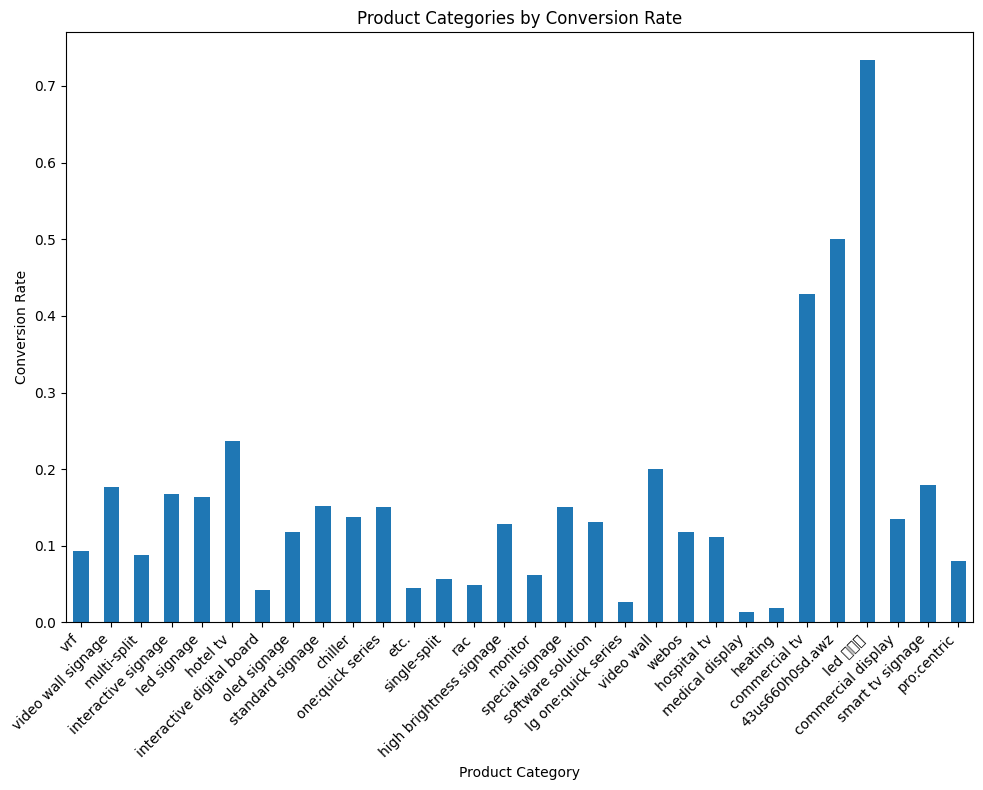

In [133]:
# 시각화
plt.figure(figsize=(10, 8))
conversion_rate['Conversion_Rate'].plot(kind='bar')
plt.title('Product Categories by Conversion Rate')
plt.xlabel('Product Category')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [85]:
product_categories = [
    'HVAC_Systems',  # HVAC 시스템 (멀티스플릿, 싱글스플릿, VRF, 칠러 등)
    'Digital_Signage',  # 디지털 사이니지 (표준, 고광도, 인터랙티브, 비디오 월, LED, OLED 사이니지 등)
    'Commercial_TV_Hotel_TV',  # 상업용 TV 및 호텔 TV
    'IT_Products',  # IT 제품 (모니터, PC, 노트북, 프로젝터, 클라우드 디바이스, 의료용 디스플레이 등)
    'Smart_Solutions',  # 스마트 솔루션 (소프트웨어 솔루션, 스마트 TV 사이니지, 웹OS 등)
    'Heating_Ventilation',  # 난방 및 환기 (난방 시스템, 환기 시스템 등)
    'Accessories',  # 액세서리 및 기타 (액세서리, ESS, 기타 등)
    'Solar_Renewable_Energy',  # 태양광 및 재생 에너지 (솔라 패널, 에너지 저장 시스템 등)
    'Medical_Healthcare_Products',  # 의료 및 건강 관련 제품 (의료용 디스플레이, 메디컬 디바이스 등)
    'Laundry_Cleaning',  # 세탁 및 청소 (세탁기, 건조기, 청소 기기 등)
    'Not Specified'  # 명시되지 않음
]

In [104]:
category_mapping = {
    'HVAC_Systems': [
        'multi-split', 'single-split', 'vrf', 'chiller', 'rac', 'all lg vrf systems', 
        'multi v5 vrf', 'split tunggal', 'multi inverter', 'multi v 5 air', 
        'multi v water 5', 'ahu', 'teto ou cassete inverter', 
        'a thermodynamic water heater', 'residential air conditioner', 'heating', 
        'control', 'pendingin', 'ar condicionado residencial', 'מברד (تشيلر)', 
        'isıtma', 'פיצול מרובה', 'تكييف وتبريد', 'lg home bliss air solution', 
        'lg paradise air solution', 'system ac'
    ],
    'Digital_Signage': [
        'standard signage', 'high brightness signage', 'interactive signage', 
        'video wall signage', 'led signage', 'oled signage', 'video wall', 
        'one:quick series', 'lg one:quick', 'special signage', 'commercial display', 
        'interactive digital board', 'uhd signage', 'smart tv signage', 
        'lg one:quick series', 'pro:centric', 'ur640', 'ur640s', 'webos', 
        'signage care solutions', 'aio | one quick', 'high brightness', 
        'digital signage', 'ultra stretch series', 'videowall', 'transparent oled', 
        'radiology displays', 'high inch 86 / 98 or 110', 'leadallin', '互動式顯示屏', 
        'led 顯示屏', 'one quick works', 'onequick series', 
        '標準顯示屏', 'videowall signage', 'one:quick flex', 'tv signage', 
        'collaboration displays', 'window facing display', 'digital signage or commercial tvs', 
        'education createboard', 'virtual production', 'led', 'videowall'
    ],
    'Commercial_TV_Hotel_TV': [
        'hotel tv', 'commercial tv', 'monior/monitor tv', 'tv', 'fhd series'
        '酒店電視', 'hospital tv', 'commercial tv,tv'
    ],
    'IT_Products': [
        'monitor', 'pc', 'laptop', 'projector', 'cloud device', 'medical display', 
        'software solution', 'webos', 'signage care solution', 'pro:centric', 'ur640', 
        'ur640s', 'signage care solutions', 'idb'
    ],
    'Smart_Solutions': [
        'smart tv', 'smart tv signage', 'lg one:quick', 'webos', 'lg smart platform'
    ],
    'Heating_Ventilation': [
        'ventilation', 'heating', 'חימום'
    ],
    'Accessories': [
        'accessories'
    ],
    'Solar_Renewable_Energy': [
        'solar', 'ess', 'energy storage system'
    ],
    'Medical_Healthcare_Products': [
        'medical display', 'medical displays'
    ],
    'Laundry_Cleaning': [
        'washing machine','dryer', 'aircare','built-in/cooking', 'dryer'
    ]
}

In [87]:
df2 = pd.DataFrame(df_train['product_category'])
df2['ori_pc'] = df_train['product_category']
df2

,product_category,ori_pc
0,multi-split,multi-split
1,multi-split,multi-split
2,single-split,single-split
3,vrf,vrf
4,multi-split,multi-split
...,...,...
59294,vrf,vrf
59295,etc.,etc.
59296,single-split,single-split
59297,etc.,etc.


In [134]:
print(df2['product_category'].value_counts().head(30))

outros                            55
technical support                 50
ogrzewanie (pompy ciepła)         29
videowall_rmk                     25
43us660h0sd.awz                   22
ledallinone                       21
solar,ess                         21
services                          20
monitor & pc                      19
aire acondicionado residencial    18
others                            16
32lq621cbsb.awz                   14
28mq780                           14
other                             13
otros                             10
id                                10
standalone                        10
calefacción                       10
lainnya                           10
solar,system ac                   10
fhd series                         9
lg one:quick                       9
sales inquiry                      9
互動式顯示屏                             8
washing machine,dryer              8
solar,aircare                      8
allinone_rmk                       7
t

In [89]:
# 모든 카테고리에 대해 열을 추가하고 0으로 초기화
for category in product_categories:
    df2[category] = 0

In [35]:
df2.loc[df2['product_category'] == 'interactive digital board','Digital_Signage'] = 1
df2.loc[df2['product_category'] == 'interactive digital board', 'product_category'] = np.nan
df2.loc[df2['ori_pc'] == 'interactive digital board']

In [107]:
value_counts = df2['product_category'].value_counts()
categories_to_update = value_counts[value_counts >= 11].index.tolist()

# 각 product_category 값을 적절한 카테고리로 매핑합니다.
for ori_category in categories_to_update:
    for category, keywords in category_mapping.items():
        # ori_category가 keywords 내에 존재하는지 확인
        if ori_category in keywords:
            # 매핑된 카테고리 이름에서 'PC_' 접두사를 제거하고 실제 카테고리 이름으로 변환
            actual_category = category.replace('PC_', '')
            # 해당 카테고리에 대한 열을 1로 설정
            df2.loc[df2['product_category'] == ori_category, actual_category] = 1
            # product_category 값을 NaN으로 설정하여 업데이트
            df2.loc[df2['product_category'] == ori_category, 'product_category'] = np.nan
            break  # 해당 ori_category에 대한 매핑을 찾았으므로 반복 종료

# 결과 확인 (예시로 몇 가지 행만 출력)
print(df2[['ori_pc'] + product_categories].head())


         ori_pc  HVAC_Systems  Digital_Signage  Commercial_TV_Hotel_TV  \
0   multi-split             1                0                       0   
1   multi-split             1                0                       0   
2  single-split             1                0                       0   
3           vrf             1                0                       0   
4   multi-split             1                0                       0   

   IT_Products  Smart_Solutions  Heating_Ventilation  Accessories  \
0            0                0                    0            0   
1            0                0                    0            0   
2            0                0                    0            0   
3            0                0                    0            0   
4            0                0                    0            0   

   Solar_Renewable_Energy  Medical_Healthcare_Products  Laundry_Cleaning  \
0                       0                            0          

In [109]:
df2.loc[df2['product_category'] == 'etc.','Not Specified'] = 1
df2.loc[df2['product_category'] == 'etc.', 'product_category'] = np.nan
df2.loc[df2['ori_pc'] == 'etc.']

,product_category,ori_pc,HVAC_Systems,Digital_Signage,Commercial_TV_Hotel_TV,IT_Products,Smart_Solutions,Heating_Ventilation,Accessories,Solar_Renewable_Energy,Medical_Healthcare_Products,Laundry_Cleaning,Not Specified
11,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
19,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
24,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
31,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
53,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59287,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
59288,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
59292,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1
59295,NaN,etc.,0,0,0,0,0,0,0,0,0,0,1


In [100]:
df2.loc[df2['product_category'] == 'monitor signage,monior/monitor tv','Digital_Signage'] = 1
df2.loc[df2['product_category'] == 'monitor signage,monior/monitor tv','Commercial_TV_Hotel_TV'] = 1
df2.loc[df2['product_category'] == 'monitor signage,monior/monitor tv', 'product_category'] = np.nan
df2.loc[df2['ori_pc'] == 'monitor signage,monior/monitor tv']

,product_category,ori_pc,HVAC_Systems,Digital_Signage,Commercial_TV_Hotel_TV,IT_Products,Smart_Solutions,Heating_Ventilation,Accessories,Solar_Renewable_Energy,Medical_Healthcare_Products,Laundry_Cleaning,Not Specified
1720,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
1721,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
1722,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
1724,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
1727,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
1736,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
1739,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
21668,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
21669,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0
21671,NaN,"monitor signage,monior/monitor tv",0,1,1,0,0,0,0,0,0,0,0


In [105]:
df2.loc[df2['product_category'] == 'monior/monitor tv,tv ','Commercial_TV_Hotel_TV'] = 2
df2.loc[df2['product_category'] == 'monior/monitor tv,tv', 'product_category'] = np.nan
df2.loc[df2['ori_pc'] == 'monior/monitor tv,tv']

,product_category,ori_pc,HVAC_Systems,Digital_Signage,Commercial_TV_Hotel_TV,IT_Products,Smart_Solutions,Heating_Ventilation,Accessories,Solar_Renewable_Energy,Medical_Healthcare_Products,Laundry_Cleaning,Not Specified
1730,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
1738,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
21661,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
21690,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
21703,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
21710,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
21729,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
22674,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
23727,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0
52514,NaN,"monior/monitor tv,tv",0,0,0,0,0,0,0,0,0,0,0


In [9]:

print(df_train['product_category'].value_counts().head(30))

interactive digital board      6154
vrf                            5640
multi-split                    3674
video wall signage             2029
etc.                           2018
led signage                    1895
interactive signage            1862
single-split                   1569
rac                            1447
oled signage                   1350
hotel tv                       1112
chiller                        1051
standard signage                996
medical display                 962
lg one:quick series             768
monitor                         762
one:quick series                668
heating                         655
high brightness signage         477
ventilation                     420
teto ou cassete inverter        308
control                         263
multi inverter                  257
ar condicionado residencial     224
high brightness                 219
software solution               191
accessories                     179
special signage             

In [7]:
print(df_train['product_category'].unique())

['multi-split' 'single-split' 'vrf' 'chiller' 'etc.' 'rac'
 'teto ou cassete inverter' nan 'software solution' 'all lg vrf systems'
 'ventilation' 'a thermodynamic water heater'
 'residential air conditioner' 'outros' 'heating' 'multi v5 vrf'
 'split tunggal' 'multi inverter' 'חימום' 'standard signage'
 'high brightness signage' 'interactive signage' 'video wall signage'
 'led signage' 'hotel tv' 'signage care solution' 'oled signage' 'idb'
 'video wall' 'one:quick series' 'commercial tv' 'lg one:quick'
 'special signage' 'other' 'accessories' 'commercial display'
 'interactive digital board' 'standard' 'uhd signage' 'smart tv signage'
 'lg one:quick series' 'pro:centric' 'ur640' 'ur640s' 'webos'
 'signage care solutions' 'aio | one quick' 'high brightness'
 'hospital tv' 'digital signage' 'monitor' 'pc' 'laptop' 'projector'
 'cloud device' 'medical display' 'washing machine,dryer' 'solar,chiller'
 'system ac,rac' 'monitor signage,commercial tv,monior/monitor tv'
 'monitor signage,moni

In [8]:
df_train[df_train['product_category'] ==  'onequick series']

,product_category,product_subcategory,product_modelname,is_converted
2009,onequick series,OneQuick Works,55CT5WJ,True
22860,onequick series,OneQuick Share,SC-00DA,False
22988,onequick series,OneQuick Flex,43HT3WJ,False
22989,onequick series,OneQuick Flex,43HT3WJ,False
22990,onequick series,OneQuick Flex,43HT3WJ,False
23061,onequick series,OneQuick Flex,43HT3WJ,False
23181,onequick series,OneQuick Flex,43HT3WJ,False
23332,onequick series,OneQuick Flex,43HT3WJ,False
23333,onequick series,OneQuick Flex,43HT3WJ,False
24213,onequick series,OneQuick Flex,43HT3WJ,False


In [8]:
product_categories = [
    'HVAC Systems',  # HVAC 시스템 (멀티스플릿, 싱글스플릿, VRF, 칠러 등)
    'Digital Signage',  # 디지털 사이니지 (표준, 고광도, 인터랙티브, 비디오 월, LED, OLED 사이니지 등)
    'Commercial TV and Hotel TV',  # 상업용 TV 및 호텔 TV
    'IT Products',  # IT 제품 (모니터, PC, 노트북, 프로젝터, 클라우드 디바이스, 의료용 디스플레이 등)
    'Smart Solutions',  # 스마트 솔루션 (소프트웨어 솔루션, 스마트 TV 사이니지, 웹OS 등)
    'Heating and Ventilation',  # 난방 및 환기 (난방 시스템, 환기 시스템 등)
    'Accessories and Others',  # 액세서리 및 기타 (액세서리, ESS, 기타 등)
    'Solar and Renewable Energy',  # 태양광 및 재생 에너지 (솔라 패널, 에너지 저장 시스템 등)
    'Medical and Healthcare Products',  # 의료 및 건강 관련 제품 (의료용 디스플레이, 메디컬 디바이스 등)
    'Laundry and Cleaning',  # 세탁 및 청소 (세탁기, 건조기, 청소 기기 등)
    'Not Specified'  # 명시되지 않음
]

In [47]:
category_mapping = {
    'PC_HVAC Systems': [
        'multi-split', 'single-split', 'vrf', 'chiller', 'rac', 'all lg vrf systems', 
        'multi v5 vrf', 'split tunggal', 'multi inverter', 'multi v 5 air', 
        'multi v water 5', 'ahu', 'teto ou cassete inverter', 
        'a thermodynamic water heater', 'residential air conditioner', 'heating', 
        'control', 'pendingin', 'ar condicionado residencial', 'מברד (تشيلر)', 
        'isıtma', 'פיצול מרובה', 'تكييف وتبريد', 'lg home bliss air solution', 
        'lg paradise air solution', 'system ac'
    ],
    'PC_Digital Signage': [
        'standard signage', 'high brightness signage', 'interactive signage', 
        'video wall signage', 'led signage', 'oled signage', 'video wall', 
        'one:quick series', 'lg one:quick', 'special signage', 'commercial display', 
        'interactive digital board', 'uhd signage', 'smart tv signage', 
        'lg one:quick series', 'pro:centric', 'ur640', 'ur640s', 'webos', 
        'signage care solutions', 'aio | one quick', 'high brightness', 
        'digital signage', 'ultra stretch series', 'videowall', 'transparent oled', 
        'radiology displays', 'high inch 86 / 98 or 110', 'leadallin', '互動式顯示屏', 
        'led 顯示屏', 'one quick works', 'onequick series', 
        '標準顯示屏', 'videowall signage', 'one:quick flex', 'tv signage', 
        'collaboration displays', 'window facing display', 'digital signage or commercial tvs', 
        'education createboard', 'virtual production', 'led', 'videowall'
    ],
    'PC_Commercial TV and Hotel TV': [
        'hotel tv', 'commercial tv', 'monior/monitor tv', 'tv', 'fhd series'
        '酒店電視', 'hospital tv'
    ],
    'PC_IT Products': [
        'monitor', 'pc', 'laptop', 'projector', 'cloud device', 'medical display', 
        'software solution', 'webos', 'signage care solution', 'pro:centric', 'ur640', 
        'ur640s', 'signage care solutions', 'idb'
    ],
    'PC_Smart Solutions': [
        'smart tv', 'smart tv signage', 'lg one:quick', 'webos', 'lg smart platform'
    ],
    'PC_Heating and Ventilation': [
        'ventilation', 'heating', 'חימום'
    ],
    'PC_Accessories and Others': [
        'accessories', 'etc.', 'other', 'lainnya', 'outros', 'אחר', 'khác', 'autres', 
        'vb.', 'others'
    ],
    'PC_Solar and Renewable Energy': [
        'solar', 'ess', 'energy storage system'
    ],
    'PC_Medical and Healthcare Products': [
        'medical display', 'medical displays'
    ],
    'PC_Laundry and Cleaning': [
        'washing machine','dryer', 'aircare','built-in/cooking', 'dryer'
    ]
}

In [62]:
df2 = pd.DataFrame(df_train['product_category'])
df2

,product_category
0,multi-split
1,multi-split
2,single-split
3,vrf
4,multi-split
...,...
59294,vrf
59295,etc.
59296,single-split
59297,etc.


In [63]:
# 모든 카테고리에 대해 열을 추가하고 0으로 초기화
for category in category_mapping:
    df2[category] = 0

In [64]:
# not_classification 변수 추가 및 초기화
df2['not_classification'] = ''

In [65]:
df2

,product_category,PC_HVAC Systems,PC_Digital Signage,PC_Commercial TV and Hotel TV,PC_IT Products,PC_Smart Solutions,PC_Heating and Ventilation,PC_Accessories and Others,PC_Solar and Renewable Energy,PC_Medical and Healthcare Products,PC_Laundry and Cleaning,not_classification
0,multi-split,0,0,0,0,0,0,0,0,0,0,
1,multi-split,0,0,0,0,0,0,0,0,0,0,
2,single-split,0,0,0,0,0,0,0,0,0,0,
3,vrf,0,0,0,0,0,0,0,0,0,0,
4,multi-split,0,0,0,0,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
59294,vrf,0,0,0,0,0,0,0,0,0,0,
59295,etc.,0,0,0,0,0,0,0,0,0,0,
59296,single-split,0,0,0,0,0,0,0,0,0,0,
59297,etc.,0,0,0,0,0,0,0,0,0,0,


In [66]:
# product_category 값을 기반으로 각 카테고리 열을 업데이트
for index, row in df2.iterrows():
    if pd.isna(row['product_category']):
        continue  # NaN 값은 건너뜁니다.
    classified = False  # 카테고리 분류 여부를 확인하는 플래그
    
    # 콤마로 구분된 값을 처리
    categories = row['product_category'].split(',')
    
    for cat in categories:
        cat = cat.strip()  # 공백 제거
        for category, keywords in category_mapping.items():
            if cat in keywords:
                df2.at[index, category] = 1
                classified = True
    
    # 분류되지 않은 경우 not_classification을 업데이트
    if not classified:
        df2.at[index, 'not_classification'] = row['product_category']

In [67]:
df2

,product_category,PC_HVAC Systems,PC_Digital Signage,PC_Commercial TV and Hotel TV,PC_IT Products,PC_Smart Solutions,PC_Heating and Ventilation,PC_Accessories and Others,PC_Solar and Renewable Energy,PC_Medical and Healthcare Products,PC_Laundry and Cleaning,not_classification
0,multi-split,1,0,0,0,0,0,0,0,0,0,
1,multi-split,1,0,0,0,0,0,0,0,0,0,
2,single-split,1,0,0,0,0,0,0,0,0,0,
3,vrf,1,0,0,0,0,0,0,0,0,0,
4,multi-split,1,0,0,0,0,0,0,0,0,0,
...,...,...,...,...,...,...,...,...,...,...,...,...
59294,vrf,1,0,0,0,0,0,0,0,0,0,
59295,etc.,0,0,0,0,0,0,1,0,0,0,
59296,single-split,1,0,0,0,0,0,0,0,0,0,
59297,etc.,0,0,0,0,0,0,1,0,0,0,


In [68]:
df2['not_classification'].unique()

array(['', 'standard', 'fhd series', '43us660h0sd.awz', '50uq801c0sb.bwz',
       'one quick:flex', 'led aio 136', '110 + video wall', 'aio', '酒店電視',
       'robots', 'oled 顯示屏', 'id',
       'meeting & screen sharedirect view leddirect view led',
       'lg customer care program', 'multi v', 'מזגנים למקום מגורים',
       'مبرد (تشيلر)', 'single split', 'multi split', 'technical support',
       'تكييفات', 'sales inquiry', 'error', '28mq780',
       'computer monitors', 'monitor & pc', 'medical monitors',
       'system air conditioner', 'monitor signage,audio/video',
       'refrigerator', 'videwall', 'ultra stretch signage',
       'mobile,audio/video', 'laec015', '55us660h0sd.bwz',
       'medical- surgical', 'ฯลฯ', 'taa lcd lfd displays', 'rac/cac',
       'حلول التدفئة', 'otros', 'sac', 'laec015-gn.awz', 'gscd046',
       '32lq621cbsb.awz', '43uh5f-h.awzm', '49vl5g-m.awzm',
       '55uq801c0sb.bwz', '43uq751c0sf.bwz', '32 / 43 pol', 'htv',
       '43uq751c0sb.bwz', '49uh / 49xf', 

In [25]:
df_train[df_train['product_category'] == 'điều hòa trung tâm chiller']

,product_category,product_subcategory,product_modelname,is_converted
58434,điều hòa trung tâm chiller,NaN,NaN,False


In [21]:
df2 = df_train['product_category']
df2

0                 multi-split
1                 multi-split
2                single-split
3                         vrf
4                 multi-split
                 ...         
59294                     vrf
59295                    etc.
59296            single-split
59297                    etc.
59298    monior/monitor tv,tv
Name: product_category, Length: 59299, dtype: object

In [11]:
# Create columns for each product category with all values set to 0
for category in product_categories:
    df_train["Product_" + category] = 0

In [8]:
for i in df_train['product_category']:
    print(i)

multi-split
multi-split
single-split
vrf
multi-split
chiller
single-split
vrf
multi-split
vrf
vrf
etc.
vrf
vrf
multi-split
chiller
vrf
single-split
single-split
etc.
multi-split
vrf
multi-split
vrf
etc.
rac
teto ou cassete inverter
vrf
vrf
vrf
single-split
etc.
vrf
rac
multi-split
nan
multi-split
multi-split
single-split
rac
single-split
multi-split
single-split
rac
multi-split
chiller
vrf
multi-split
vrf
vrf
multi-split
multi-split
software solution
etc.
multi-split
etc.
single-split
all lg vrf systems
vrf
vrf
vrf
vrf
ventilation
vrf
all lg vrf systems
a thermodynamic water heater
rac
rac
etc.
vrf
vrf
etc.
etc.
single-split
multi-split
multi-split
etc.
vrf
vrf
etc.
rac
etc.
rac
vrf
single-split
etc.
vrf
multi-split
residential air conditioner
vrf
outros
vrf
vrf
rac
vrf
etc.
single-split
etc.
single-split
single-split
multi-split
etc.
single-split
single-split
chiller
single-split
multi-split
multi-split
multi-split
etc.
vrf
multi-split
multi-split
multi-split
etc.
vrf
vrf
vrf
vrf
mult

In [ ]:
product_categories = [
    'HVAC Systems',  # HVAC 시스템 (멀티스플릿, 싱글스플릿, VRF, 칠러 등)
    'Digital Signage',  # 디지털 사이니지 (표준, 고광도, 인터랙티브, 비디오 월, LED, OLED 사이니지 등)
    'Commercial TV and Hotel TV',  # 상업용 TV 및 호텔 TV
    'IT Products',  # IT 제품 (모니터, PC, 노트북, 프로젝터, 클라우드 디바이스, 의료용 디스플레이 등)
    'Smart Solutions',  # 스마트 솔루션 (소프트웨어 솔루션, 스마트 TV 사이니지, 웹OS 등)
    'Heating and Ventilation',  # 난방 및 환기 (난방 시스템, 환기 시스템 등)
    'Accessories and Others',  # 액세서리 및 기타 (액세서리, ESS, 기타 등)
    'Solar and Renewable Energy',  # 태양광 및 재생 에너지 (솔라 패널, 에너지 저장 시스템 등)
    'Medical and Healthcare Products',  # 의료 및 건강 관련 제품 (의료용 디스플레이, 메디컬 디바이스 등)
    'Laundry and Cleaning',  # 세탁 및 청소 (세탁기, 건조기, 청소 기기 등)
    'Not Specified'  # 명시되지 않음
]

In [ ]:
# 분류 함수 정의
def classify_product_category(text, classifier, categories):
    if pd.isna(text):
        return {category: 0 for category in categories}
    classification_result = classifier(text, categories, multi_label=True)
    labels = classification_result['labels']
    scores = classification_result['scores']
    return {label: score for label, score in zip(labels, scores)}

# 각 product_category에 대해 분류 실행 및 데이터프레임 업데이트
def update_product_categories(df, classifier, categories):
    category_columns = {category: [] for category in categories}
    for text in tqdm(df['product_category'], desc="Classifying"):
        result = classify_product_category(text, classifier, categories)
        for category in categories:
            category_columns[category].append(result.get(category, 0))
    for category, values in category_columns.items():
        df[category] = values
    return df

In [ ]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

# 텍스트 데이터 예시
product_category_texts_train = df_train['product_category']#.fillna("Unknown").tolist()  # 결측치 처리
product_category_texts_test = df_test['product_category']#.fillna("Unknown").tolist()  # 결측치 처리

In [ ]:
# 훈련 데이터셋에 대한 의도 분류 (병렬 처리)
product_categor_intents_train = classify_intents(product_category_texts_train, classifier, product_categories)
# 테스트 데이터셋에 대한 의도 분류 (병렬 처리)
product_categor_intents_test = classify_intents(product_category_texts_train, classifier, product_categories)

In [51]:
product_categories = [
    'HVAC Systems',  # HVAC 시스템 (멀티스플릿, 싱글스플릿, VRF, 칠러 등)
    'Digital Signage',  # 디지털 사이니지 (표준, 고광도, 인터랙티브, 비디오 월, LED, OLED 사이니지 등)
    'Commercial TV and Hotel TV',  # 상업용 TV 및 호텔 TV
    'IT Products',  # IT 제품 (모니터, PC, 노트북, 프로젝터, 클라우드 디바이스, 의료용 디스플레이 등)
    'Smart Solutions',  # 스마트 솔루션 (소프트웨어 솔루션, 스마트 TV 사이니지, 웹OS 등)
    'Heating and Ventilation',  # 난방 및 환기 (난방 시스템, 환기 시스템 등)
    'Accessories and Others',  # 액세서리 및 기타 (액세서리, ESS, 기타 등)
    'Solar and Renewable Energy',  # 태양광 및 재생 에너지 (솔라 패널, 에너지 저장 시스템 등)
    'Medical and Healthcare Products',  # 의료 및 건강 관련 제품 (의료용 디스플레이, 메디컬 디바이스 등)
    'Laundry and Cleaning',  # 세탁 및 청소 (세탁기, 건조기, 청소 기기 등)
    'Not Specified'  # 명시되지 않음
]

In [52]:
# One-Hot Encoding을 위한 열 추가
for category in product_categories:
    df_train[f'Category_{category}'] = 0
    df_test[f'Category_{category}'] = 0

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   product_category                          39925 non-null  object
 1   product_subcategory                       9235 non-null   object
 2   product_modelname                         9229 non-null   object
 3   is_converted                              59299 non-null  bool  
 4   Category_HVAC Systems                     59299 non-null  int64 
 5   Category_Digital Signage                  59299 non-null  int64 
 6   Category_Commercial TV and Hotel TV       59299 non-null  int64 
 7   Category_IT Products                      59299 non-null  int64 
 8   Category_Smart Solutions                  59299 non-null  int64 
 9   Category_Heating and Ventilation          59299 non-null  int64 
 10  Category_Accessories and Others           5929

In [54]:
# CUDA 사용 가능 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Zero-shot classification 파이프라인 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0 if device == 'cuda' else -1)

Using cuda device


In [61]:
def classify_and_update(df, product_categories, classifier):
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        if pd.isna(row['product_category']):
            continue
        categories = row['product_category'].split(',')
        for category in categories:
            category = category.strip()
            result = classifier(category, product_categories, multi_label=True)  # 수정된 부분
            print(result)
            for classified_category in result['labels']:
                df.at[index, f'Category_{classified_category}'] += 1

# 분류기 초기화
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [62]:
# 함수 호출
classify_and_update(df_train[:10], product_categories, classifier)
classify_and_update(df_test[:10], product_categories, classifier)

  0%|          | 0/10 [00:00<?, ?it/s]

{'sequence': 'multi-split', 'labels': ['Accessories and Others', 'Solar and Renewable Energy', 'Heating and Ventilation', 'Smart Solutions', 'Digital Signage', 'Laundry and Cleaning', 'Commercial TV and Hotel TV', 'IT Products', 'HVAC Systems', 'Medical and Healthcare Products', 'Not Specified'], 'scores': [0.8396984338760376, 0.8217014670372009, 0.6549105644226074, 0.6354566812515259, 0.624230682849884, 0.5821155309677124, 0.5221746563911438, 0.4944862425327301, 0.4584753215312958, 0.43390920758247375, 0.007067884784191847]}
{'sequence': 'multi-split', 'labels': ['Accessories and Others', 'Solar and Renewable Energy', 'Heating and Ventilation', 'Smart Solutions', 'Digital Signage', 'Laundry and Cleaning', 'Commercial TV and Hotel TV', 'IT Products', 'HVAC Systems', 'Medical and Healthcare Products', 'Not Specified'], 'scores': [0.8396984338760376, 0.8217014670372009, 0.6549105644226074, 0.6354566812515259, 0.624230682849884, 0.5821155309677124, 0.5221746563911438, 0.4944862425327301, 

  0%|          | 0/10 [00:00<?, ?it/s]

{'sequence': 'hospital tv', 'labels': ['Medical and Healthcare Products', 'Commercial TV and Hotel TV', 'Heating and Ventilation', 'Accessories and Others', 'Not Specified', 'Smart Solutions', 'HVAC Systems', 'Digital Signage', 'Laundry and Cleaning', 'Solar and Renewable Energy', 'IT Products'], 'scores': [0.7272452712059021, 0.10608755052089691, 0.06510856002569199, 0.025321736931800842, 0.024623006582260132, 0.0099122803658247, 0.005312344990670681, 0.0015317335491999984, 0.000916175777092576, 0.0006959115853533149, 0.0005519650294445455]}
{'sequence': 'led signage', 'labels': ['Digital Signage', 'Smart Solutions', 'Heating and Ventilation', 'Accessories and Others', 'Solar and Renewable Energy', 'Medical and Healthcare Products', 'HVAC Systems', 'Laundry and Cleaning', 'Commercial TV and Hotel TV', 'IT Products', 'Not Specified'], 'scores': [0.6281193494796753, 0.3910035789012909, 0.37195655703544617, 0.34595248103141785, 0.2973528206348419, 0.21749117970466614, 0.16254889965057373

In [60]:
df_train

,product_category,product_subcategory,product_modelname,is_converted,Category_HVAC Systems,Category_Digital Signage,Category_Commercial TV and Hotel TV,Category_IT Products,Category_Smart Solutions,Category_Heating and Ventilation,Category_Accessories and Others,Category_Solar and Renewable Energy,Category_Medical and Healthcare Products,Category_Laundry and Cleaning,Category_Not Specified
0,multi-split,NaN,NaN,True,3,3,3,3,3,3,3,3,3,3,3
1,multi-split,NaN,NaN,True,3,3,3,3,3,3,3,3,3,3,3
2,single-split,NaN,NaN,True,3,3,3,3,3,3,3,3,3,3,3
3,vrf,NaN,NaN,True,3,3,3,3,3,3,3,3,3,3,3
4,multi-split,NaN,NaN,True,3,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,vrf,NaN,NaN,False,0,0,0,0,0,0,0,0,0,0,0
59295,etc.,NaN,NaN,False,0,0,0,0,0,0,0,0,0,0,0
59296,single-split,NaN,NaN,False,0,0,0,0,0,0,0,0,0,0,0
59297,etc.,NaN,NaN,False,0,0,0,0,0,0,0,0,0,0,0


In [15]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_category     39925 non-null  object
 1   product_subcategory  9235 non-null   object
 2   product_modelname    9229 non-null   object
 3   is_converted         59299 non-null  bool  
dtypes: bool(1), object(3)
memory usage: 1.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_category     3413 non-null   object
 1   product_subcategory  793 non-null    object
 2   product_modelname    562 non-null    object
 3   is_converted         5271 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 128.8+ KB
None


In [16]:
PSI_df_train = df_train.drop('is_converted', axis = 1)
PSI_df_test = df_test.drop('is_converted', axis = 1)

PSI_df_train.to_csv('./preprocessing_data/PSI(상품밎서비스정보)_train.csv')
PSI_df_test.to_csv('./preprocessing_data/PSI(상품밎서비스정보)_test.csv')